In [14]:
# Make tensorflow logs less verbose

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
)



In [15]:

# ─── 1) DISCOVER IMAGES & MULTI-CLASS LABELS ──────────────────────────────────
# load_files es un metodo de sickit_Learn, se dan las categorias.
data = load_files(
    container_path='.',
    categories=['binary_star', 'exoplanet','normal_star', 'pulsating_star'],
    load_content=False,
    shuffle=True,
    random_state=413
)
file_paths = np.array(data['filenames'])
orig_targets = data['target']
target_names = data['target_names']
print(orig_targets)
print(target_names)
print(file_paths)


[1 0 3 ... 0 2 3]
['binary_star', 'exoplanet', 'normal_star', 'pulsating_star']
['.\\exoplanet\\291_light_curve.png' '.\\binary_star\\204_light_curve.png'
 '.\\pulsating_star\\26_light_curve.png' ...
 '.\\binary_star\\70_light_curve.png' '.\\normal_star\\95_light_curve.png'
 '.\\pulsating_star\\382_light_curve.png']


In [16]:

# ─── 2) BUILD BINARY LABELS ───────────────────────────────────────────────────
# 1 for exoplanet, 0 for everything else. This is also unchanged.
y = np.array([1 if target_names[t] == 'exoplanet' else 0
              for t in orig_targets], dtype=int)


In [17]:
# ─── 3) LOAD & PREPROCESS IMAGES FOR CNN ─────────────────────────────────────
# We load images, convert to grayscale, and resize.
# CRITICAL CHANGE: We DO NOT flatten them. CNNs need the 2D shape.
images = []
for fp in file_paths:
    img = (Image.open(fp)
           .convert('L')  # grayscale
           .resize((128, 128), Image.Resampling.LANCZOS))
    images.append(np.array(img, dtype=np.float32))

# Convert the list of images to a single 4D numpy array
# Shape will be (n_samples, height, width, channels)
X = np.array(images)

In [18]:

# ─── 4) SCALE PIXELS & RESHAPE FOR TENSORFLOW ────────────────────────────────
# Scale pixel values from [0, 255] to [0, 1] for better NN performance
X_scaled = X / 255.0

# Add a 'channels' dimension at the end. For grayscale, this is 1.
# The final shape will be (n_samples, 28, 28, 1)
X_scaled = np.expand_dims(X_scaled, axis=-1)
print(X_scaled[0])

[[[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 ...

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.99607843]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]]


In [19]:

# ─── 5) TRAIN/TEST SPLIT ─────────────────────────────────────────────────────
# x is the features(images)
# y is the labels, the ground truth: the class for each image. in this case 1 or 0(exoplanet or not)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=413,
    stratify=y  # Ensures train/test sets have proportional classes
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (1924, 128, 128, 1)
Test data shape: (482, 128, 128, 1)


In [20]:
#Two separate the arrays as we desire: 

#indices = np.arange(len(X_scaled))
#train_idx, test_idx = train_test_split(
#    indices,
#    test_size=0.2,
#    random_state=413,
#    stratify=y
#)

# Now you can do:
#X_train = X_scaled[train_idx]
#y_train = y[train_idx]
#X_test  = X_scaled[test_idx]
#y_test  = y[test_idx]

#print("Train indices:", train_idx)
#print("Test indices: ", test_idx)

In [21]:
### Test
#model = tf.keras.Sequential([
    #tf.keras.layers.Input((128, 128, 1)),

    #tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    #tf.keras.layers.MaxPooling2D(),

  #  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  #  tf.keras.layers.MaxPooling2D(),

    # You can add a third conv block for a bit more capacity:
    # tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(),

   # tf.keras.layers.GlobalAveragePooling2D(),

#    tf.keras.layers.Dense(64, activation='relu'),
#    tf.keras.layers.Dropout(0.3),            # <— helps prevent over-fitting
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])


In [22]:

# ─── 6) DEFINE THE CNN MODEL ─────────────────────────────────────────────────
model = tf.keras.Sequential([
    # Adjust input shape to your actual image size
    tf.keras.layers.Input(shape=(128, 128, 1)),
    
    # First conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Instead of Flatten(), do global average pooling:
    tf.keras.layers.GlobalAveragePooling2D(),
    # This turns (batch, h, w, channels) → (batch, channels)
    
    # Optional small Dense head if you still want some FC layers
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Final binary output
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# ─── 7) TRAIN THE CNN MODEL ──────────────────────────────────────────────────
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=50,  # 25 epochs is a good starting point. 700 is likely too much and causes overfitting.
    batch_size=32,
    validation_data=(X_test, y_test), # Evaluate on test data at the end of each epoch
    verbose=1 # Show progress
)
print("--- Model Training Finished ---\n")
model.save('exoplanet_cnn_model.keras')
print("Model saved to exoplanet_cnn_model.pth")


--- Starting Model Training ---
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9804 - loss: 0.0590 - val_accuracy: 0.9876 - val_loss: 0.0515
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9755 - loss: 0.0670 - val_accuracy: 0.9876 - val_loss: 0.0509
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9826 - loss: 0.0573 - val_accuracy: 0.9876 - val_loss: 0.0540
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9792 - loss: 0.0618 - val_accuracy: 0.9855 - val_loss: 0.0477
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9839 - loss: 0.0518 - val_accuracy: 0.9876 - val_loss: 0.0428
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9846 - loss: 0.0534 - val_accuracy: 0.9855 - val_loss: 0.0449
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9859 - loss: 0.0416 - val_accuracy: 0.9689 - val_loss: 0.0691
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.98

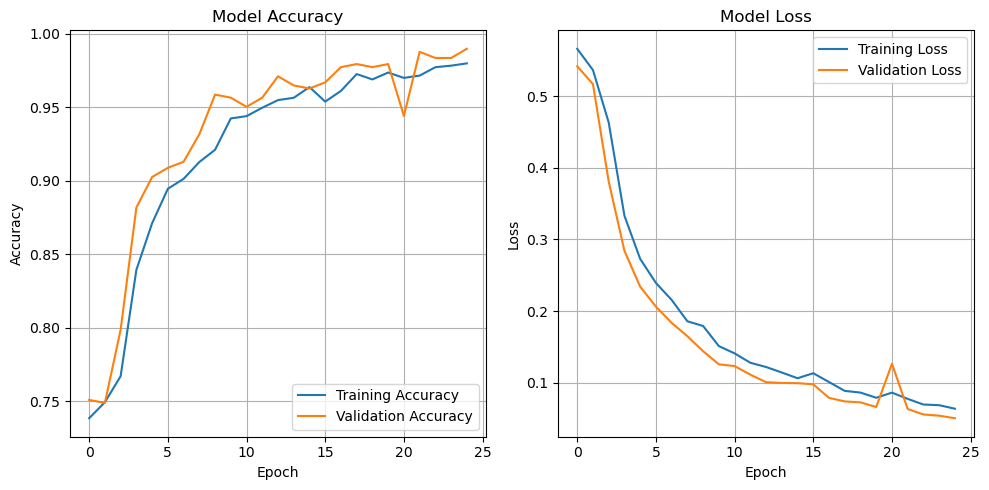

Test Accuracy: 98.963%
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


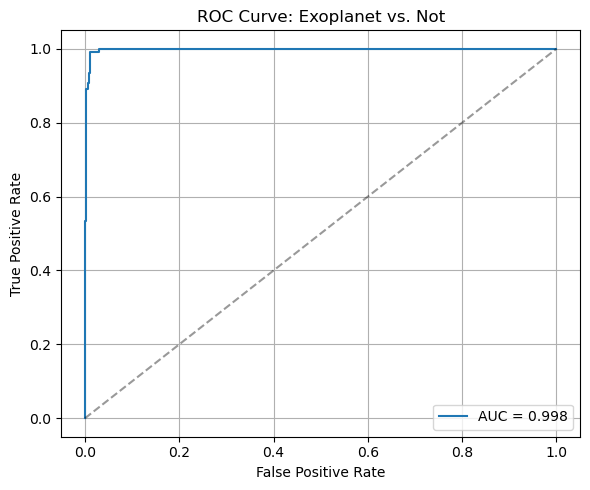

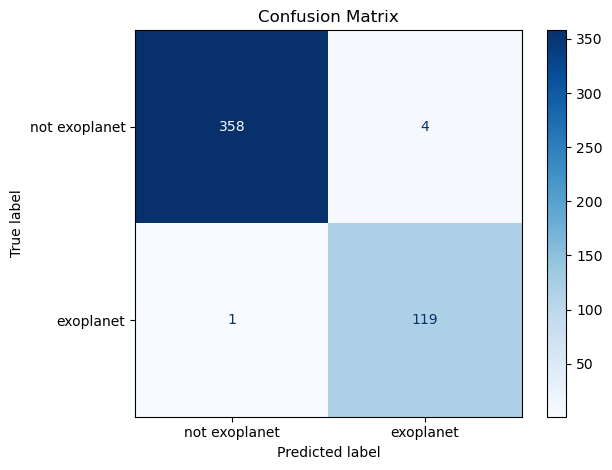

In [24]:



# ─── 8) PLOT TRAINING & VALIDATION CURVES ───────────────────────────────────
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


# ─── 9) EVALUATE ON TEST SET ─────────────────────────────────────────────────
# Get final performance metrics on the test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.3%}")

# Get predictions: `predict` gives probabilities, so we round to get 0 or 1
y_scores = model.predict(X_test).flatten() # a.k.a. y_proba
y_pred = np.round(y_scores)                # Class predictions


# ─── 10) ROC CURVE ───────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Exoplanet vs. Not")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
#plt.savefig("roc_curve.png")
plt.show()

# ─── 11) CONFUSION MATRIX ───────────────────────────────────────────────────
# We can use sklearn's display function, but we'll create the matrix manually
# to show how it's done with Keras predictions.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["not exoplanet", "exoplanet"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [25]:
### Testing the model ###

Loaded TensorFlow model successfully!

--- Prediction ---
Image: .\exoplanet\test_exo.png
Predicted: non-exoplanet (confidence: 0.0002)


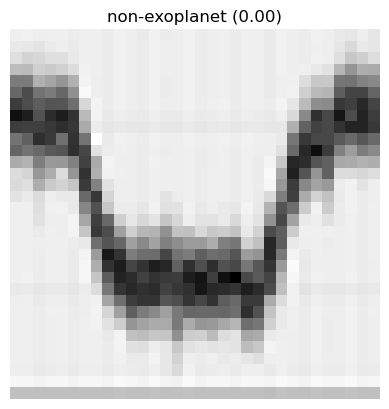


--- Prediction ---
Image: .\exoplanet\1100_light_curve.png
Predicted: non-exoplanet (confidence: 0.0000)


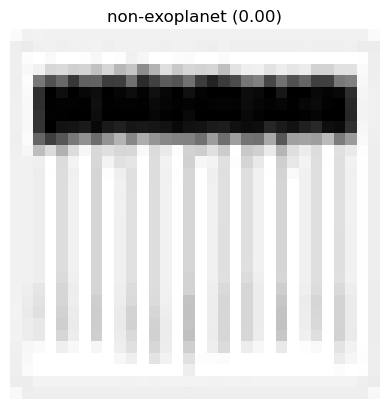


--- Prediction ---
Image: .\normal_star\test_normal.png
Predicted: non-exoplanet (confidence: 0.0000)


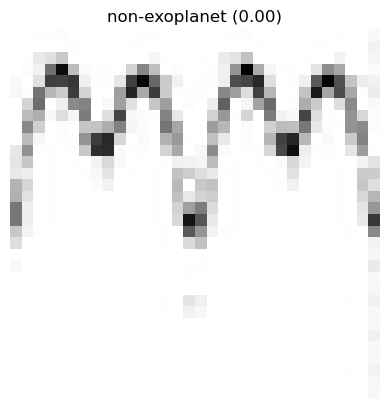


--- Prediction ---
Image: .\normal_star\1100_light_curve.png
Predicted: non-exoplanet (confidence: 0.0000)


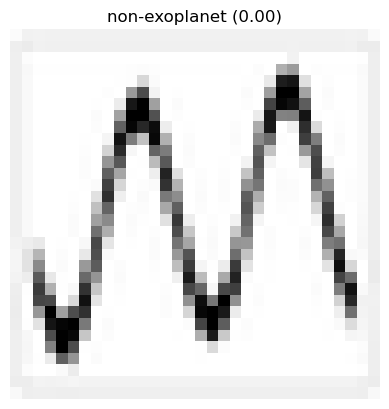


--- Prediction ---
Image: .\binary_star\1100_light_curve.png
Predicted: non-exoplanet (confidence: 0.0000)


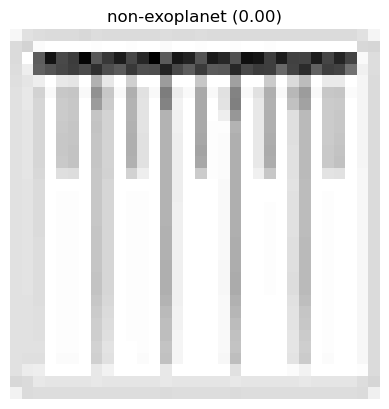


--- Prediction ---
Image: .\pulsating_star\1100_light_curve.png
Predicted: non-exoplanet (confidence: 0.0000)


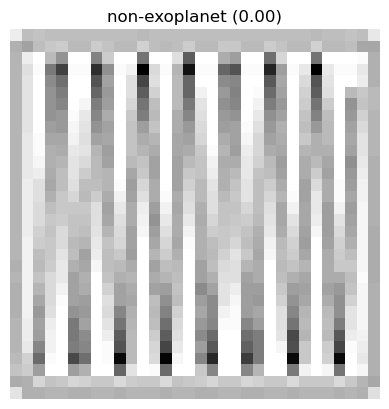


--- Prediction ---
Image: .\binary_star\test.png
Predicted: non-exoplanet (confidence: 0.0000)


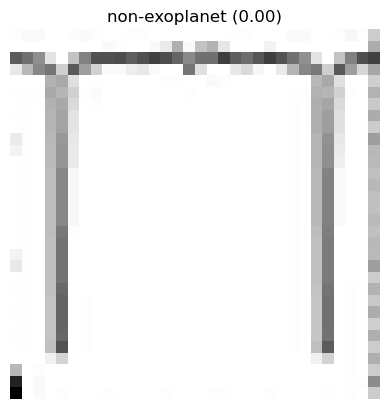

In [26]:

# ==============================================================================
#   LOAD THE TRAINED KERAS MODEL
# ==============================================================================
model = tf.keras.models.load_model('exoplanet_cnn_model.keras')
print("Loaded TensorFlow model successfully!")

# ==============================================================================
#  3. PREDICTION FUNCTION
# ==============================================================================
def predict_single_image_tf(model, image_path, class_names):
    """Preprocess and predict a single grayscale image."""
    img = Image.open(image_path).convert('L').resize((32, 32), Image.Resampling.LANCZOS)
    arr = np.array(img, dtype=np.float32) / 255.0
    tensor = arr.reshape((1, 32, 32, 1))
    
    prob = model.predict(tensor, verbose=0).item()
    idx = int(prob > 0.5)
    label = class_names[idx]
    
    print(f"Image: {image_path}")
    print(f"Predicted: {label} (confidence: {prob:.4f})")
    
    plt.imshow(arr, cmap='gray')
    plt.title(f"{label} ({prob:.2f})")
    plt.axis('off')
    plt.show()

# ==============================================================================
#  4. TEST EXAMPLES
# ==============================================================================
class_names = ['non-exoplanet','exoplanet']
test_images = ['.\\exoplanet\\test_exo.png','.\\exoplanet\\1100_light_curve.png', '.\\normal_star\\test_normal.png','.\\normal_star\\1100_light_curve.png','.\\binary_star\\1100_light_curve.png','.\\pulsating_star\\1100_light_curve.png','.\\binary_star\\test.png']

for img_path in test_images:
    print("\n--- Prediction ---")
    predict_single_image_tf(model, img_path, class_names)